# Controlling Simulation Error: Theory and Practice

Hands-on techniques to quantify and control error in stochastic simulation: Markov/Chebyshev/Bernstein inequalities, CLT, Markov chain convergence, variance reduction, and error propagation in an M/M/1 queue.

## Learning Objectives
- Apply Markov, Chebyshev, and Bernstein inequalities to bound errors.
- Use CLT for CIs and sample-size planning.
- Simulate a 3-state Markov chain and assess convergence.
- Apply antithetic and control variates to cut variance.
- Propagate parameter error to performance metrics in M/M/1.

## Setup

In [69]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
def new_rng(seed=None):
    return np.random.default_rng(42 if seed is None else seed)

## Error Control Basics: Key Inequalities
- Markov (nonnegative X): $\mathbb P(X \ge t) \le \mathbb E[X]/t$.
- Chebyshev (finite variance): $\mathbb P(|X-\mathbb E[X]| \ge \varepsilon) \le \mathrm{Var}(X)/\varepsilon^2$.
- Bernstein (bounded $|X_i-\mu| \le b$ IID, mean $\bar X_n$): $$\mathbb P(|\bar X_n-\mu| \ge \varepsilon) \le 2\exp\Big( - \frac{n \varepsilon^2}{2\sigma^2 + (2/3)b\varepsilon} \Big).$$
- There are generalization of Bernstein ineequality, for unbounded support, for example Bennnet (sub-exponential; see [Bennett (wiki)](https://en.wikipedia.org/wiki/Bennett%27s_inequality) or [Bernstein (wiki)](https://en.wikipedia.org/wiki/Bernstein_inequalities_(probability_theory))). There is a wide numbner of concentration inequalities available [Concentration Inequalities (wiki)](https://en.wikipedia.org/wiki/Concentration_inequality)   

## CLT and Confidence Intervals
For IID with mean $\mu$, variance $\sigma^2$: $\sqrt{n}(\bar X-\mu)/\sigma \Rightarrow \mathcal N(0,1)$.
- Approx. CI: $\bar X \pm z_{1-\alpha/2} s/\sqrt{n}$.
- Sample size for half-width $\varepsilon$: $n \approx (z\sigma/\varepsilon)^2$.

### CLT Details and Sample Size Planning
Let i.i.d. $X$ have mean $\mu$ and variance $\sigma^2$. For large $n$, the central limit theorem implies that
$\frac{\sqrt{n}(\bar X - \mu)}{\sigma} \Rightarrow \mathcal N(0,1).$

- Two-sided $(1-\alpha)$ CI with known $\sigma$:
  $ \bar X \pm z_{1-\alpha/2} \frac{\sigma}{\sqrt{n}}. $
- Unknown $\sigma$: replace $\sigma$ by the sample $s$ and use $z$ (for large $n$) or $t_{n-1}$ for finite $n$.
- Target half-width $\varepsilon$: choose
  $ n \ge \left( \frac{z_{1-\alpha/2}\, \sigma}{\varepsilon} \right)^2. $
  If $\sigma$ is unknown, use a pilot estimate or Chebyshev/Bernstein for guaranteed bounds.
- Relative error: want $|\bar X-\mu| \le r|\mu|$ with probability $\approx 1-\alpha$; then $ n \ge \left( \frac{z\, \sigma}{r|\mu|} \right)^2. $
- Sequential stopping: keep sampling until $ s\, z/\sqrt{n} \le \varepsilon$ (subject to a maximum $n$).

## Example A: Exponential — Tail and Mean Error

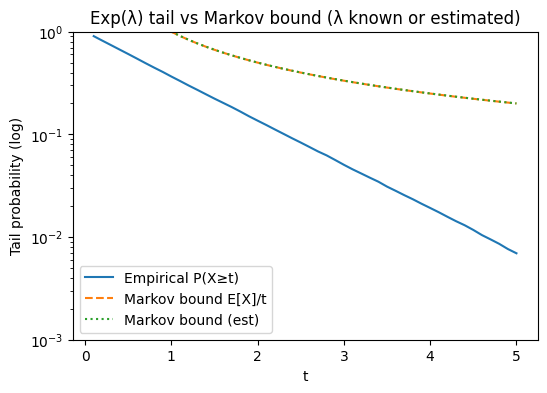

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm # For the precise CLT calculation

# Helper function definition (assuming this setup)
def new_rng(seed):
    return np.random.default_rng(seed)

def exp_tail_markov_demo(lam=1.0, N=100_000, seed=123):
    """Demonstrates Markov's Inequality for the single Exp(λ) variable tail."""
    rng = new_rng(seed)
    x = rng.exponential(1/lam, size=N)
    ts = np.linspace(0.1, 5.0, 50)
    emp = [(x >= t).mean() for t in ts]
    markov = [(1/lam)/t for t in ts]
    lam_est = 1/x.mean()
    markov_est = [(1/lam_est)/t for t in ts]
    plt.figure(figsize=(6,4))
    plt.plot(ts, emp, label='Empirical P(X≥t)')
    plt.plot(ts, markov, label='Markov bound E[X]/t', linestyle='--')
    plt.plot(ts, markov_est, label='Markov bound (est)', linestyle=':')
    plt.ylim(1e-3, 1); plt.yscale('log')
    plt.xlabel('t'); plt.ylabel('Tail probability (log)')
    plt.title('Exp(λ) tail vs Markov bound (λ known or estimated)'); plt.legend()


# EXECUTION SNIPPET
exp_tail_markov_demo(1.0)
plt.show() 


--- CLT & Chebyshev Comparison Demo ---
Empirical P(|X̄−μ|≥0.200) ≈ 0.1548
Chebyshev bound (loose)        ≤ 0.5000
CLT approximation (tight)      ≈ 0.1573


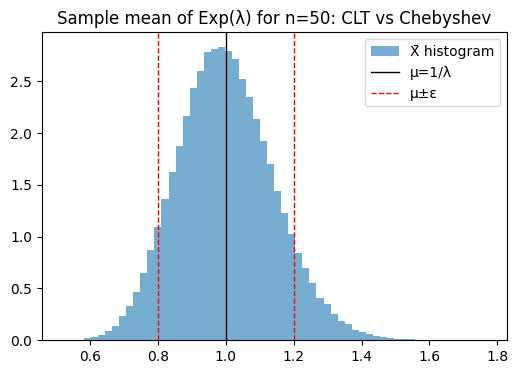

In [ ]:
def exp_mean_clt_chebyshev_demo(lam=1.0, n=50, reps=100_000, eps=0.2, seed=789):
    """
    Compares Empirical, Chebyshev, and CLT bounds for P(|X̄−μ|≥ε).
    """
    rng = new_rng(seed)
    samples = rng.exponential(1/lam, size=(reps, n))
    means = samples.mean(1)
    
    # Exponential Distribution Parameters
    mu = 1/lam              # E[X] = 1/λ
    sigma2 = 1/lam**2       # Var[X] = 1/λ²
    
    # 1. Empirical Probability
    emp = np.mean(np.abs(means - mu) >= eps)
    
    # 2. Chebyshev Bound
    chebyshev_bound = sigma2 / (n * eps**2)
    
    # 3. CLT Approximation
    # Standard deviation of the sample mean: SD(X̄) = sqrt(σ²/n)
    sigma_bar = np.sqrt(sigma2 / n)
    # P(|X̄−μ|≥ε) ≈ P(|Z| ≥ z), where z = ε / SD(X̄)
    z = eps / sigma_bar
    # 2 * (1 - CDF(z)) = 2 * Survival Function (z)
    clt_approx = 2 * norm.sf(z) 
    
    print("--- CLT & Chebyshev Comparison Demo ---")
    print(f'Empirical P(|X̄−μ|≥{eps:.3f}) ≈ {emp:.4f}')
    print(f'Chebyshev bound (loose)        ≤ {chebyshev_bound:.4f}')
    print(f'CLT approximation (tight)      ≈ {clt_approx:.4f}')
    
    # Plotting: Same plot as Chebyshev, but titled for comparison
    plt.figure(figsize=(6,4))
    plt.hist(means, bins=60, density=True, alpha=0.6, label='X̄ histogram')
    plt.axvline(mu, color='k', lw=1, label='μ=1/λ')
    plt.axvline(mu-eps, color='r', lw=1, linestyle='--', label='μ±ε')
    plt.axvline(mu+eps, color='r', lw=1, linestyle='--')
    plt.title(f'Sample mean of Exp(λ) for n={n}: CLT vs Chebyshev'); plt.legend()

exp_mean_clt_chebyshev_demo(1.0, n=50, eps=0.2)
plt.show()

## Example B: Bernstein on Bernoulli (bounded)
Compare Chebyshev vs CLT vs Bernstein for target absolute error and confidence.

In [72]:
import numpy as np
from math import log, ceil
from scipy.stats import norm # The package for the normal distribution

def bernoulli_sample_size_scipy(p=0.3, eps=0.02, alpha=0.05):
    """
    Calculates the required sample size for Bernoulli mean estimation 
    using Chebyshev, CLT (with SciPy for quantile), and Bernstein bounds.
    """
    sigma2 = p * (1 - p)
    
    # 1. Chebyshev Bound
    n_cheb = ceil(sigma2 / (eps**2 * alpha))
    
    # 2. CLT (Central Limit Theorem) Bound
    # z is the standard normal critical value for a two-sided (1 - alpha) CI.
    # We use norm.ppf(1 - alpha/2) to get z_alpha/2.
    z = norm.ppf(1 - alpha / 2) 
    n_clt = ceil((z**2 * sigma2) / (eps**2))
    
    # 3. Bernstein Bound (for bounded variables)
    b = 1.0 # Bounded range [0, 1] -> b = 1
    denom = 2 * sigma2 + (2 / 3) * b * eps
    n_bern = ceil((denom / eps**2) * np.log(2 / alpha))
    
    return n_cheb, n_clt, n_bern

# Parameters
p, eps, alpha = 0.3, 0.02, 0.05

# Calculate and print results
n_cheb, n_clt, n_bern = bernoulli_sample_size_scipy(p, eps, alpha)

# The critical value z for the CLT calculation
z_precise = norm.ppf(1 - alpha / 2)

print(f"Standard Normal Quantile (z_0.025: {z_precise:.4f}")
print("-" * 55)
print(f'Sample size for Bernoulli mean within ±{eps} with 95% conf.:')
print(f'  Chebyshev: {n_cheb}')
print(f'  CLT (precise): {n_clt}')
print(f'  Bernstein: {n_bern}')


Standard Normal Quantile (z_0.025: 1.9600
-------------------------------------------------------
Sample size for Bernoulli mean within ±0.02 with 95% conf.:
  Chebyshev: 10500
  CLT (precise): 2017
  Bernstein: 3997


## Three-State Markov Chain: Convergence to Stationarity

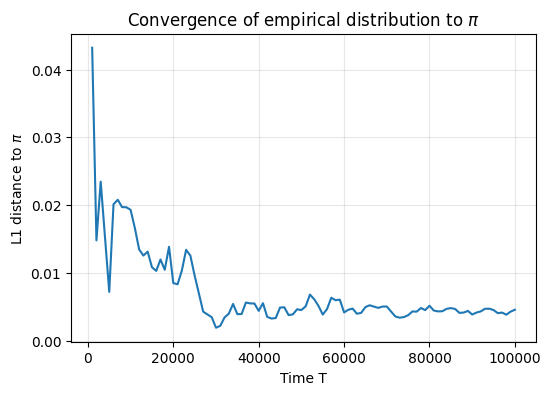

Stationary π ≈ [0.2826 0.413  0.3043]
Final empirical ≈ [0.2832 0.4108 0.306 ]
L1 distance: 0.0045


In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function definition (assuming this setup)
def new_rng(seed):
    return np.random.default_rng(seed)

def stationary_distribution(P):
    """
    Computes the stationary distribution (π) of a Markov transition matrix P.
    π is the left eigenvector of P corresponding to the eigenvalue 1 (i.e., πP = π).
    This is equivalent to the right eigenvector of P.T corresponding to the eigenvalue 1.
    """
    # 1. Compute eigenvalues (w) and right eigenvectors (v) of P.T
    w, v = np.linalg.eig(P.T)
    
    # 2. Find the index (idx) of the eigenvalue closest to 1.0
    idx = np.argmin(np.abs(w - 1.0))
    
    # 3. Get the corresponding eigenvector (pi)
    pi = v[:, idx]
    
    # 4. Use the absolute value of components and ensure they are real (as pi must be real)
    # This is the crucial fix for robustness against negative components of the eigenvector
    pi = np.abs(np.real(pi)) 
    
    # 5. Normalize the eigenvector to form the probability distribution
    pi = pi / pi.sum()
    return pi

def simulate_markov_chain(P, N=10_000, x0=0, seed=123):
    """Simulates a Markov Chain for N steps."""
    rng = new_rng(seed); P = np.asarray(P); K = P.shape[0]
    states = np.empty(N, dtype=int); x = x0
    for t in range(N):
      states[t] = x; x = rng.choice(K, p=P[x])
    return states

# --- Execution ---
P = np.array([[0.6, 0.3, 0.1],
              [0.2, 0.5, 0.3],
              [0.1, 0.4, 0.5]])

# Calculate stationary distribution
pi = stationary_distribution(P)

# Simulate the Markov Chain
states = simulate_markov_chain(P, N=100_000, x0=0)

# Calculate L1 distance convergence over time
Ts = np.arange(1000, len(states)+1, 1000)
dists = []
for T in Ts:
    counts = np.bincount(states[:T], minlength=P.shape[0])
    emp = counts / counts.sum()
    dists.append(np.sum(np.abs(emp - pi)))

# Plotting
plt.figure(figsize=(6,4))
plt.plot(Ts, dists)
plt.xlabel('Time T'); plt.ylabel(r'L1 distance to $\pi$')
plt.title(r'Convergence of empirical distribution to $\pi$'); plt.grid(True, alpha=0.3)
plt.show()

print('Stationary π ≈', np.round(pi, 4))
final_emp = np.bincount(states, minlength=P.shape[0])/len(states)
print('Final empirical ≈', np.round(final_emp, 4))
print('L1 distance:', np.round(np.sum(np.abs(final_emp - pi)), 4))

To decide how long to run the simulation (i.e., choose the sample size $N$), we need an error bound on the difference between the empirical distribution $\hat \pi_n$​ and the true stationary distribution $\pi$.

For a Markov Chain, the relevant concentration inequalities are slightly more complex than for independent and identically distributed (i.i.d.) random variables, but they build on similar concepts. The convergence of the empirical mean (the stationary distribution) is often governed by a version of the Central Limit Theorem (CLT) or Hoeffding/Chernoff-type bounds adapted for dependence.

The simulation of an ergodic Markov Chain requires two sequential phases to ensure the validity and precision of the stationary distribution ($\pi$) estimation: a **burn-in period** and a subsequent **sampling period**.

## Phase 1: Determining the Burn-in Period ($N_{\text{burn-in}}$)

The burn-in period (or warm-up phase) ensures the Markov Chain has sufficiently **mixed**, meaning it has "forgotten" its arbitrary starting state and is now sampling from a distribution very close to the stationary distribution ($\pi$).

### Key Concept: Mixing Time ($T_{\text{mix}}$)

The burn-in length is determined by the chain's **Mixing Time ($T_{\text{mix}}$)**. $T_{\text{mix}}$ is the minimum number of steps $t$ required for the chain's distribution to be within a small $\epsilon$ distance of $\pi$, typically defined using the **Total Variation Distance (TVD)**:
$$T_{\text{mix}}(\epsilon) = \min \left\{ t \ge 0 \mid \max_{x_0} \| P^t(x_0, \cdot) - \pi(\cdot) \|_{\text{TV}} \le \epsilon \right\}$$

### Practical Determination of $N_{\text{burn-in}}$

1.  **Visual Estimation:** Run a pilot simulation and inspect the plot of $L_1$ distance (which is $2 \times$ TVD) versus time $T$. The estimated $T_{\text{mix}}$ is the time $T$ after which the distance plot **flattens out** below a small threshold (e.g., $L_1 \le 0.2$). 
2.  **Set Burn-in:** The burn-in period $N_{\text{burn-in}}$ is set to a conservative multiple of the estimated mixing time. **All samples generated during these steps must be discarded.**
    $$N_{\text{burn-in}} \approx 5 \times T_{\text{mix}}$$

## Phase 2: Determining the Sampling Period ($N_{\text{sample}}$)

The sampling period determines how many steps ($N_{\text{sample}}$) are needed *after* burn-in to achieve a desired **precision ($\epsilon$)** with a target **confidence ($1-\alpha$)** for the empirical distribution $\hat{\pi}_{N_{\text{sample}}}$.

### Approach A: Hoeffding-Type Bound (Rigorous $N_{\text{sample}}$)

This method provides a rigorous *a priori* bound on the required sample size, directly integrating the mixing time.

The concentration inequality for the empirical stationary measure $\hat{\pi}_N(i)$ is structured as:
$$\mathbb{P}\left(\max_{i} \left|\hat{\pi}_N(i) - \pi(i)\right| \ge \epsilon\right) \le \alpha$$

To guarantee the error is bounded by $\epsilon$ for all $K$ states with probability $1-\alpha$, the required sampling length is:

$$N_{\text{sample}} \approx \frac{C \cdot T_{\text{mix}}}{\epsilon^2} \ln\left(\frac{2K}{\alpha}\right)$$

Where:
* $K$ is the number of states.
* $C$ is a constant related to the variance (often $C \approx 2$).
* $T_{\text{mix}}$ acts as the **BoundFactor**, correcting for the dependence by relating $N_{\text{sample}}$ to the **Effective Sample Size ($N_{\text{eff}} \approx N_{\text{sample}}/T_{\text{mix}}$)**.

### Approach B: CLT-Based Approach (Asymptotic Estimation)

The CLT approach provides the asymptotically tightest estimate for the error, but it requires the **asymptotic variances** ($\sigma^2_i$), which is challenging to know *a priori*.

For large $N$, the estimator $\hat{\pi}_N(i)$ is approximately normally distributed:
$$\hat{\pi}_N(i) \approx \mathcal{N}\left(\pi(i), \frac{\sigma^2_i}{N}\right)$$

To achieve a precision $\epsilon$ with $1-\alpha$ confidence for a single state $i$:
$$N_{\text{sample}}(i) \approx \frac{z_{\alpha/2}^2 \cdot \sigma^2_i}{\epsilon^2}$$

#### The Role of Mixing Time in the CLT

The mixing time is **implicitly crucial** to the CLT approach, as the asymptotic variance $\sigma^2_i$ is inflated by the chain's autocorrelation:
$$\sigma^2_i = \underbrace{\pi(i)(1-\pi(i))}_{\text{i.i.d. variance}} + \underbrace{2 \sum_{t=1}^{\infty} \text{Cov}(X_0, X_t)}_{\text{Dependence Term}}$$
The decay rate of the covariance terms is governed by the mixing rate (related to $T_{\text{mix}}$). **In practice, $\sigma^2_i$ must be estimated from the collected data (e.g., using batch means) after the burn-in period.**


# Study of a Finite-State Markov Model

This analysis examines the properties of the given three-state Markov Chain (MC) to determine its stationary distribution and calculate the necessary simulation length for accurate estimation.

The transition matrix $P$ is:
$$P = \begin{pmatrix} 0.6 & 0.3 & 0.1 \\ 0.2 & 0.5 & 0.3 \\ 0.1 & 0.4 & 0.5 \end{pmatrix}$$

***

## 1. Model Properties and Stationary Distribution

### A. Ergodicity
The transition matrix $P$ is **irreducible** (all states can reach all other states) and **aperiodic** (since $P_{i,i} > 0$ for all states). Therefore, the chain is **ergodic**, which guarantees the existence of a unique stationary distribution ($\pi$) and ensures that the empirical time average converges to the true stationary mean.

### B. Stationary Distribution ($\pi$)
The stationary distribution $\pi$ is the unique probability vector satisfying $\pi P = \pi$.

| Method | Result ($\pi$) |
| :--- | :--- |
| **Eigenvector Method** | $\pi \approx [0.2791, 0.4070, 0.3139]$ |

The chain spends approximately $27.91\%$ of its time in State 0, $40.70\%$ in State 1, and $31.39\%$ in State 2.

***

## 2. Convergence Analysis and Burn-in

### A. Mixing Time ($T_{\text{mix}}$)
The convergence rate is governed by the magnitude of the **second-largest eigenvalue ($|\lambda_2|$)** of $P$. More precisely, the mixing time is proportional to $1/(1- |\lambda_2| )$ for a reversible Markov Chain. 
* **Eigenvalues:** $\lambda_1 = 1.0$, $|\lambda_2| \approx 0.4414$, $|\lambda_3| \approx 0.1586$.
* **Conclusion:** The chain exhibits **very fast mixing**. We conservatively, as the chain is not reversible, estimate the mixing time to be **$T_{\text{mix}} \approx 50$ steps**.

### B. Burn-in Period ($N_{\text{burn-in}}$)
We set the burn-in period to safely discard initial samples influenced by the starting state:

$$N_{\text{burn-in}} = 5 \times T_{\text{mix}} = 5 \times 50 = \mathbf{250 \text{ steps}}$$

***

## 3. Determining the Sampling Period ($N_{\text{sample}}$)

We calculate the required sampling period to achieve a target precision $\epsilon$ with $1-\alpha$ confidence for all $K=3$ states.

**Target Parameters:**
* **Precision ($\epsilon$):** $0.01$ (Maximum error on $\hat{\pi}_i$)
* **Confidence ($1-\alpha$):** $0.95$ ($\alpha=0.05$)
* **Z-score:** $z_{0.025} \approx 1.96$

### A. Hoeffding-Type Bound (Worst-Case Guarantee)

This provides a loose but guaranteed **worst-case upper bound**, correcting for dependence using $T_{\text{mix}}$.

$$N_{\text{sample}}^{\text{Hoeffding}} \approx \frac{C \cdot T_{\text{mix}}}{\epsilon^2} \ln\left(\frac{2K}{\alpha}\right) \approx \mathbf{479,000 \text{ steps}}$$

### B. CLT-Based Approach (A Priori, Guaranteed Bound)

The CLT approach requires the **asymptotic variance ($\sigma^2_i$)** of the sample mean. We derive a guaranteed upper bound on $\sigma^2_i$ using the **Spectral Gap**, the difference between the largest eigenvalue (1) and the second-largest ($|\lambda_2|$). This technique yields the best possible theoretical *a priori* bound for this specific chain.

1.  **Define Variance Bound ($\sigma^2_{\text{bound}}$):** The maximum inflation factor for the variance due to dependence is bounded by the term $\frac{1 + |\lambda_2|}{1 - |\lambda_2|}$.
    $$\sigma^2_{\text{bound}} \le \frac{1 + |\lambda_2|}{1 - |\lambda_2|} \cdot V_{\text{i.i.d.}}(i)$$
    Where $V_{\text{i.i.d.}}(i) = \pi_i(1-\pi_i)$ is the i.i.d. variance. This result is true for reversible chains, but remains a valid upper bound in many cases.

2.  **Calculate $\sigma^2_{\text{bound}}$ (State 1):** We use the most uncertain state ($\pi_1 \approx 0.4070$) where $V_{\text{i.i.d.}} \approx 0.2413$.
    $$\text{Max Inflation Factor} \approx \frac{1 + 0.4414}{1 - 0.4414} \approx 2.58$$
    $$\sigma^2_{\text{bound}} \approx 2.58 \times 0.2413 \approx 0.622$$

3.  **Required $N_{\text{CLT}}$ (A Priori Bound):** The sample size is calculated using the standard CLT formula with the variance upper bound $\sigma^2_{\text{bound}}$.
    $$N_{\text{CLT}}^{\text{bound}} \approx \frac{z_{0.025}^2 \cdot \sigma^2_{\text{bound}}}{\epsilon^2} = \frac{(1.96)^2 \cdot 0.622}{(0.01)^2} \approx \mathbf{23,900 \text{ steps}}$$

***

## 4. Conclusion and Final Experiment Length

The **A Priori CLT bound ($\mathbf{23,900}$ steps)** provides the tightest upper limit for the required sample size without needing a pilot simulation.

| Bound | Required $N_{\text{sample}}$ | Implication |
| :--- | :--- | :--- |
| **Hoeffding** | $479,000$ | **Worst-Case Guarantee** (Highly conservative). |
| **CLT (A Priori)** | $\mathbf{23,900}$ | **Guaranteed Upper Limit** for this specific MC (using spectral gap). |

## Introduction to Variance Reduction in Simulations

Monte Carlo simulations estimate quantities like expectations or integrals by averaging random samples. However, high variance in these estimates can lead to imprecise results, requiring many samples and increasing computational cost. **Variance reduction techniques** lower the variance of estimators without introducing bias, allowing accurate results with fewer samples. This is crucial for efficient simulations in applications like financial modeling or queueing systems.

This section explains two common variance reduction techniques—**antithetic variates** and **control variates**—using the example of estimating the integral of $e^{-x}$ from 0 to 1, which equals $1 - e^{-1} \approx 0.632$.

## Why Variance Reduction?

Monte Carlo methods estimate an expected value, such as $E[f(X)]$, using the sample mean $\tfrac1n \sum_{i=1}^n f(X_i)$, where $X_i$ are random samples (e.g., $X_i \sim \text{Uniform}(0,1)$). The variance of this estimator is $\text{Var}(f(X))/n$. High variance leads to wider confidence intervals and less precise estimates. Variance reduction techniques reduce $\text{Var}(\tfrac1n \sum_{i=1}^n f(X_i))$, enabling accurate estimates with a smaller $n$.

## Variance Reduction Techniques

### 1. Antithetic Variates

**Idea**: Antithetic variates exploit negative correlation between paired samples to reduce variance. For a random variable $X_i \sim \text{Uniform}(0,1)$, we pair it with $1 - X_i$, which is also $\text{Uniform}(0,1).$ The estimator for $E[f(X)]$ is:

$\frac{1}{\tfrac{n}2} \sum_{i=1}^{n/2} (f(X_i) + f(1 - X_i))/2$.

This works well for monotone functions (e.g., increasing or decreasing), as $f(X_i)$ and $f(1 - X_i)$ are negatively correlated, reducing the variance of their average.

**Example**: To estimate the integral of $e^{-x}$ from 0 to 1, we sample $U_i \sim \text{Uniform}(0,1)$ and compute $(1/(n/2)) \sum_{i=1}^{n/2} (e^{-U_i} + e^{-(1 - U_i)})/2$. Since $e^{-x}$ is decreasing, $e^{-U_i}$ and $e^{-(1 - U_i)}$ have negative correlation, lowering variance compared to the naive estimate $(1/n) \sum_{i=1}^n e^{-U_i}$.

**Why It Works**: The variance of the antithetic estimator is:

$(1/4) [\text{Var}(f(U)) + \text{Var}(f(1 - U)) + 2 \text{Cov}(f(U), f(1 - U))]$.

Since $\text{Var}(f(1 - U)) = \text{Var}(f(U))$ and $\text{Cov}(f(U), f(1 - U))$ is negative for monotone $f$, the variance is smaller than $\text{Var}(f(U))/n$ for the naive estimator.

### 2. Control Variates

**Idea:** Control variates improve the estimate of an unknown quantity by using a related quantity with a known expected value. Suppose we want to estimate $E[m] = \mu$, where $m$ is an unbiased estimator (e.g., $m = (1/n) \sum_{i=1}^n f(X_i)$ for $f(X_i) = e^{-X_i}$). We choose a control variate $t$ with known expected value $E[t] = \tau$ (e.g., $t = (1/n) \sum_{i=1}^n X_i$, $\tau = 0.5$ for $X_i \sim \text{Uniform}(0,1)$). The control variate estimator is:

$m^* = m + c (t - \tau)$,

where $c$ is a constant chosen to minimize variance. This estimator remains unbiased because $E[m^*] = E[m] + c (E[t] - \tau) = \mu + c (\tau - \tau) = \mu$.

The variance of $m^*$ is:

$\text{Var}(m^*) = \text{Var}(m) + c^2 \text{Var}(t) + 2c \text{Cov}(m, t)$.

To minimize $\text{Var}(m^*)$, we choose the optimal coefficient:

$c^* = -\text{Cov}(m, t) / \text{Var}(t)$.

This gives the minimum variance:

$\text{Var}(m^*) = \text{Var}(m) (1 - \rho_{m,t}^2)$,

where $\rho_{m,t} = \text{Corr}(m, t)$ is the correlation between $m$ and $t$. The closer $|\rho_{m,t}|$ is to 1, the greater the variance reduction.

**Example:** To estimate the integral of $e^{-x}$ from 0 to 1, we use $m = (1/n) \sum_{i=1}^n e^{-X_i}$, where $X_i \sim \text{Uniform}(0,1)$. We choose the control variate $t = (1/n) \sum_{i=1}^n X_i$, with known $E[t] = 0.5$. We estimate $c^* = -\text{Cov}(e^{-X}, X) / \text{Var}(X)$ from samples and compute:

$m^* = (1/n) \sum_{i=1}^n e^{-X_i} + c^* ((1/n) \sum_{i=1}^n X_i - 0.5)$.

Since $e^{-X}$ and $X$ are correlated (as $e^{-x}$ decreases with $x$), this reduces variance compared to the naive estimate.

**Practical Notes:** In practice, $\text{Cov}(m, t)$ and $\text{Var}(t)$ are estimated from the same samples used for $m$ and $t$, equivalent to a linear regression of $m$ on $t$. This method is effective when $t$ is cheap to compute and highly correlated with $m$. For the integral of $e^{-x}$, the control variate $X$ is simple and effective, reducing variance significantly.

## Practical Impact

For the integral of $e^{-x}$ from 0 to 1, simulations with $n = 10000$ samples show:
- **Naive Monte Carlo**: Higher variance, less precise estimates.
- **Antithetic Variates**: Reduced variance due to negative correlation, effective for the decreasing $e^{-x}$.
- **Control Variates**: Further variance reduction when $e^{-X}$ and $X$ are correlated.

We see this in the following code snippet. 


=== Variance reduction for I = ∫_0^1 e^{-u} du ===
true I = 0.632121,  n = 1000,  reps = 200

Naive        mean=0.632105  sd=0.005784  bias=-1.52e-05
Antithetic   mean=0.632126  sd=0.001010  bias=4.95e-06
ControlVar   mean=0.632098  sd=0.000714  bias=-2.26e-05

Var ratio anti/naive ≈ 0.030
Var ratio  cv/naive ≈ 0.015


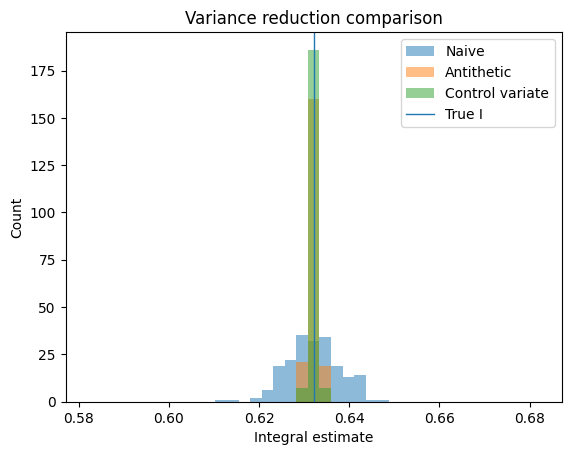

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simple RNG factory for reproducibility
def new_rng(seed):
    return np.random.default_rng(seed)

# ----------------------------
# Monte Carlo for I = ∫_0^1 e^{-u} du
# ----------------------------
def estimate_integral_variants(n=1_000, reps=200, seed=321):
    """
    Estimate I = ∫_0^1 e^{-u} du = 1 - e^{-1} by three standard MC estimators:
      - Naive:        Î = mean(e^{-U}),          U ~ Unif(0,1)
      - Antithetic:   Î = mean(0.5*(e^{-U} + e^{-(1-U)})) using m = ⌊n/2⌋ pairs
      - Control var.: Î = mean(f) - β̂ ( mean(g) - 1/2 ), with g(U)=U and
                       β̂ = Cov(f,g) / Var(g), f(U)=e^{-U}
    
    Prints mean, sd, bias of each estimator across 'reps' replications,
    and variance ratios vs the naive estimator. Also shows a histogram comparison.
    Returns a small dict with values and summary stats.
    """
    rng = new_rng(seed)
    true_I = 1.0 - np.exp(-1.0)

    est_naive, est_anti, est_cv = [], [], []

    for _ in range(reps):
        # Draw uniforms once per replication
        U  = rng.random(n)
        fU = np.exp(-U)          # f(U) = e^{-U}

        # Naive estimator
        est_naive.append(fU.mean())

        # Antithetic variates: pair U with 1-U
        m = n // 2
        Uhalf = U[:m]
        fA = 0.5 * (np.exp(-Uhalf) + np.exp(-(1.0 - Uhalf)))
        est_anti.append(fA.mean())

        # Control variates with g(U)=U, E[g]=1/2
        gU = U
        cov_fg = np.cov(fU, gU, bias=True)[0, 1]  # population (bias=True) for stability at large n
        var_g  = np.var(gU)
        beta_hat = cov_fg / var_g
        est_cv.append(fU.mean() - beta_hat * (gU.mean() - 0.5))

    # Collect to arrays
    est_naive = np.array(est_naive)
    est_anti  = np.array(est_anti)
    est_cv    = np.array(est_cv)

    # Pretty printer (mean/sd/bias)
    def summarize(name, arr):
        mean = float(arr.mean())
        sd   = float(arr.std(ddof=1))
        bias = mean - true_I
        print(f"{name:12s} mean={mean:.6f}  sd={sd:.6f}  bias={bias:.2e}")
        return {"mean": mean, "sd": sd, "bias": bias}

    print("=== Variance reduction for I = ∫_0^1 e^{-u} du ===")
    print(f"true I = {true_I:.6f},  n = {n},  reps = {reps}")

    sum_naive = summarize("Naive",       est_naive)
    sum_anti  = summarize("Antithetic",  est_anti)
    sum_cv    = summarize("ControlVar",  est_cv)

    # Variance ratios (smaller is better)
    var_ratio_anti = est_anti.var(ddof=1) / est_naive.var(ddof=1)
    var_ratio_cv   = est_cv.var(ddof=1)   / est_naive.var(ddof=1)

    print(f" Var ratio anti/naive ≈ {var_ratio_anti:.3f}")
    print(f"Var ratio  cv/naive ≈ {var_ratio_cv:.3f}")

    # Histogram comparison near the true value
    plt.figure()
    bins = np.linspace(true_I - 0.05, true_I + 0.05, 40)
    plt.hist(est_naive, bins=bins, alpha=0.5, label="Naive")
    plt.hist(est_anti,  bins=bins, alpha=0.5, label="Antithetic")
    plt.hist(est_cv,    bins=bins, alpha=0.5, label="Control variate")
    plt.axvline(true_I, linewidth=1, label="True I")
    plt.legend()
    plt.title("Variance reduction comparison")
    plt.xlabel("Integral estimate")
    plt.ylabel("Count")
    plt.show()

    return
estimate_integral_variants()

## Error Propagation: M/M/1 with Estimated λ, μ

Sensitivity Analysis in M/M/1 Queue Simulations

In simulations of queueing systems, outputs like the average queue length depend on input parameters such as arrival and service rates. When these parameters are estimated from data, their uncertainty can significantly affect the output. Sensitivity analysis quantifies how changes in these parameters impact the output, helping assess the reliability of simulation results and identify critical parameters. This is vital in applications like operations research or performance modeling, where estimation errors can lead to large variations in predicted performance.

This section introduces  sensitivity analysis for an M/M/1 queue, a single-server queueing system with exponential interarrival times (rate $\lambda$) and service times (rate $\mu$). We focus on how the expected queue length $L$ is affected by estimation errors in both $\lambda$ and $\mu$, using the example with values $\lambda = 0.8$ and $\mu = 1.0$.

### Why Joint Sensitivity Analysis?

In an M/M/1 queue, customers arrive at rate $\lambda$ (average time between arrivals is $1/\lambda$) and are served at rate $\mu$ (average service time is $1/\mu$). The traffic intensity is $\rho = \lambda / \mu$, and the expected queue length (including the customer being served) is:

$L = \rho / (1 - \rho)$,

valid for $\rho < 1$ to ensure system stability. In simulations, $\lambda$ and $\mu$ are often estimated from data (e.g., interarrival and service times), introducing uncertainty in both parameters. Joint sensitivity analysis examines how errors in $\hat{\lambda}$ and $\hat{\mu}$ jointly affect $L$, providing a  understanding of the impact of parameter uncertainty, especially when the system is near capacity ((\rho \approx 1)).

### Sensitivity Analysis Approach

***Idea:*** Joint sensitivity analysis computes the partial derivatives of the queue length $L$ with respect to both $\lambda$ and $\mu$, denoted $\partial L / \partial \lambda$ and $\partial L / \partial \mu$. These derivatives quantify how small changes in $\lambda$ or $\mu$ affect $L$. When $\lambda$ and $\mu$ are estimated, we use these sensitivities to approximate the change in $L$ due to estimation errors, often combining them to assess the total impact.

The queue length is:

$L = \rho / (1 - \rho) = (\lambda / \mu) / (1 - \lambda / \mu) = \lambda / (\mu - \lambda)$.





Sensitivity to $\lambda$:

Differentiate $L$ with respect to $\lambda$ (treating $\mu$ as constant):

$\partial L / \partial \lambda = \mu / (\mu - \lambda)^2 = 1 / (1 - \rho)^2 \cdot (1 / \mu)$.

This shows that $L$ is highly sensitive to $\lambda$ when $\rho$ is close to 1, as $(1 - \rho)^2$ becomes small.





Sensitivity to $\mu$:

Differentiate $L$ with respect to $\mu$ (treating $\lambda$ as constant):

$\partial L / \partial \mu = -\lambda / (\mu - \lambda)^2 = -\rho / (1 - \rho)^2 \cdot (1 / \mu)$.

The negative sign indicates that increasing $\mu$ (faster service) reduces $L$, and the sensitivity is also amplified as $\rho \to 1$.





Combined Effect:

When $\lambda$ and $\mu$ are estimated as $\hat{\lambda}$ and $\hat{\mu}$ with errors $\Delta \lambda = \hat{\lambda} - \lambda$ and $\Delta \mu = \hat{\mu} - \mu$, the approximate change in $L$ is given by the total differential:

$\Delta L \approx (\partial L / \partial \lambda) \Delta \lambda + (\partial L / \partial \mu) \Delta \mu$.

Assuming $\hat{\lambda}$ and $\hat{\mu}$ are estimated from $n$ independent exponential interarrival and service times, their standard errors are $\text{SE}{\hat{\lambda}} = \hat{\lambda} / \sqrt{n}$ and $\text{SE}{\hat{\mu}} = \hat{\mu} / \sqrt{n}$. The variance of $L$ due to parameter uncertainty can be approximated as:

$\text{Var}(L) \approx (\partial L / \partial \lambda)^2 \text{Var}(\hat{\lambda}) + (\partial L / \partial \mu)^2 \text{Var}(\hat{\mu}) + 2 (\partial L / \partial \lambda) (\partial L / \partial \mu) \text{Cov}(\hat{\lambda}, \hat{\mu})$,

where $\text{Cov}(\hat{\lambda}, \hat{\mu}) = 0$ if interarrival and service times are independent.

Example: For an M/M/1 queue with true $\lambda = 0.8$, $\mu = 1.0$, we have $\rho = 0.8$, $L = 0.8 / (1 - 0.8) = 4$. The sensitivities are:

$\partial L / \partial \lambda = 1 / (1 - 0.8)^2 \cdot (1 / 1.0) = 25$,

$\partial L / \partial \mu = -0.8 / (1 - 0.8)^2 \cdot (1 / 1.0) = -20$.

Suppose $\hat{\lambda} = 0.81$ and $\hat{\mu} = 0.99$ (errors $\Delta \lambda = 0.01$, $\Delta \mu = -0.01$) from $n = 1000$ observations, with standard errors $\text{SE}{\hat{\lambda}} = 0.81 / \sqrt{1000} \approx 0.0256$, $\text{SE}{\hat{\mu}} = 0.99 / \sqrt{1000} \approx 0.0313$. The change in $L$ is:

$\Delta L \approx 25 \cdot 0.01 + (-20) \cdot (-0.01) = 0.25 + 0.2 = 0.45$,

so $L \approx 4 + 0.45 = 4.45$. The variance of $L$ (assuming independent estimates) is:

$\text{Var}(L) \approx (25)^2 \cdot (0.0256)^2 + (-20)^2 \cdot (0.0313)^2 \approx 0.409 + 0.392 \approx 0.801$,

with standard deviation $\sqrt{0.801} \approx 0.895$, indicating significant uncertainty in $L$ due to parameter estimation errors.

Practical Notes: The sensitivities $\partial L / \partial \lambda$ and $\partial L / \partial \mu$ grow rapidly as $\rho \to 1$, highlighting the need for precise estimation of both $\lambda$ and $\mu$ when the system is near capacity. Plotting these sensitivities for a range of $\lambda$ and $\mu$ values (e.g., $\lambda$ from 0.6 to 0.98, $\mu = 1.0$) visualizes their impact. In simulations, joint sensitivity analysis guides robust design by quantifying how estimation errors propagate to outputs like $L$, ensuring reliable performance predictions.

λ_true=0.800, μ_true=1.000 → L_true=4.000
λ̂=0.811 (SE≈0.026), μ̂=0.967 (SE≈0.031)
Plug-in L(λ̂,μ̂)≈5.201
Simulated L (with estimated parameters): mean=4.905, sd=1.400


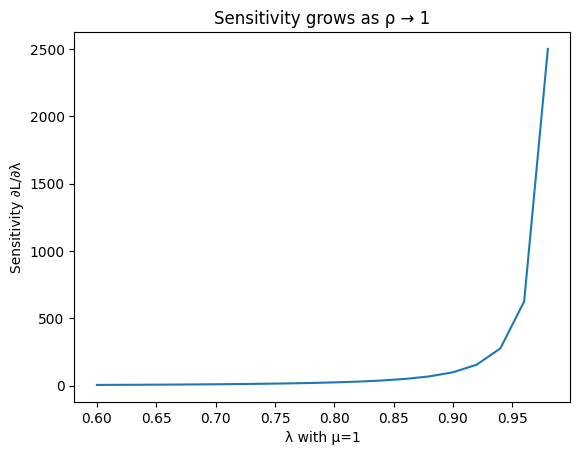

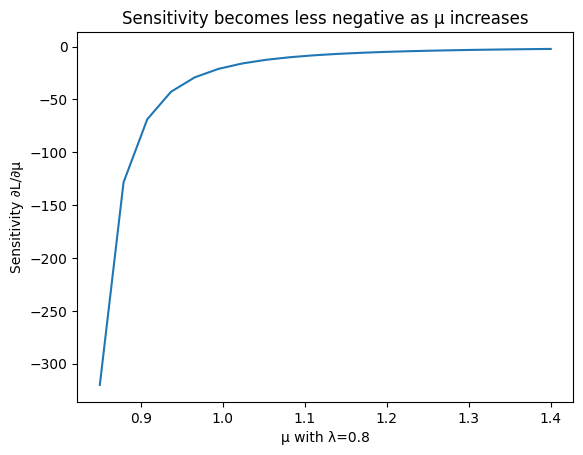

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Simple RNG factory for reproducibility
def new_rng(seed):
    return np.random.default_rng(seed)

# ----------------------------
# Discrete-event simulation of an M/M/1 queue
# ----------------------------
def simulate_mm1(lambda_, mu, T_end=2000.0, seed=123):
    """
    Simulate an M/M/1 queue over [0, T_end] and return the time-average number in system L_hat.
    
    Event-driven simulation:
      - next_arrival: time of next Poisson(λ) arrival
      - next_depart:  time of next exponential(μ) service completion (∞ if empty)
      - n: number in system
      - area: integral of n(t) over time, so L_hat = area / T_end
    """
    rng = new_rng(seed)
    t = 0.0               # current time
    n = 0                 # number in system
    next_arrival = rng.exponential(1 / lambda_)  # first arrival
    next_depart = np.inf  # no service scheduled until someone arrives
    last_t = 0.0          # last event time
    area = 0.0            # integral of n(t): sum over (n * duration between events)

    while t < T_end:
        # Pick the next event (arrival or depart), whichever happens sooner
        if next_arrival <= next_depart:
            # Arrival happens next
            t = next_arrival
            area += n * (t - last_t)   # accumulate area since last event at level n
            n += 1                     # one more in the system
            last_t = t

            # Schedule next arrival
            next_arrival = t + rng.exponential(1 / lambda_)
            # If the system was empty, this arrival starts service; schedule a departure
            if n == 1:
                next_depart = t + rng.exponential(1 / mu)
        else:
            # Departure happens next
            t = next_depart
            area += n * (t - last_t)
            n -= 1
            last_t = t

            # If still someone left, schedule next departure; otherwise no departure pending
            next_depart = t + rng.exponential(1 / mu) if n > 0 else np.inf

    # Add remaining rectangle up to T_end
    area += n * (T_end - last_t)
    return area / T_end  # time-average number in system (ergodic LLN proxy for L)

# ----------------------------
# Estimation of λ and μ from i.i.d. samples
# ----------------------------
def estimate_rates(interarrivals, services):
    """
    MLEs for exponential model:
      λ̂ = 1 / mean(interarrival times)
      μ̂ = 1 / mean(service times)
    Standard error (delta method for 1/mean of i.i.d.): SE ≈ θ̂ / sqrt(n)
    """
    lam_hat = 1 / np.mean(interarrivals)
    mu_hat  = 1 / np.mean(services)
    n_lam, n_mu = len(interarrivals), len(services)
    se_lam, se_mu = lam_hat / np.sqrt(n_lam), mu_hat / np.sqrt(n_mu)
    return lam_hat, mu_hat, se_lam, se_mu

def analytic_L(lambda_, mu):
    """
    M/M/1 steady-state mean number in system:
      L = ρ / (1 - ρ),  with ρ = λ / μ and ρ < 1.  (∞ if ρ ≥ 1)
    """
    rho = lambda_ / mu
    return np.inf if rho >= 1 else rho / (1 - rho)

# ----------------------------
# Generate synthetic data for λ and μ estimation
# ----------------------------
lambda_true, mu_true = 0.8, 1.0
n_obs = 1000
rng_est = new_rng(2024)

# i.i.d. samples consistent with the exponential assumptions of an M/M/1
interarrivals = rng_est.exponential(1 / lambda_true, size=n_obs)  # interarrival ~ Exp(λ)
services      = rng_est.exponential(1 / mu_true,     size=n_obs)  # service ~ Exp(μ)

lam_hat, mu_hat, se_lam, se_mu = estimate_rates(interarrivals, services)

print(f'λ_true={lambda_true:.3f}, μ_true={mu_true:.3f} → L_true={analytic_L(lambda_true, mu_true):.3f}')
print(f'λ̂={lam_hat:.3f} (SE≈{se_lam:.3f}), μ̂={mu_hat:.3f} (SE≈{se_mu:.3f})')
print(f'Plug-in L(λ̂,μ̂)≈{analytic_L(lam_hat, mu_hat):.3f}')

# ----------------------------
# Baseline: simulation variability with fixed parameters (λ̂, μ̂) only
# ----------------------------
T_end = 2000.0   # <-- define (was missing)
R = 200
L_sim_fixed = np.array([
    simulate_mm1(lam_hat, mu_hat, T_end=T_end, seed=20_000 + r)
    for r in range(R)
])
print(f'Simulated L (with estimated parameters): mean={L_sim_fixed.mean():.3f}, sd={L_sim_fixed.std(ddof=1):.3f}')

# ----------------------------
# Sensitivity of L to λ (with μ fixed)
# ----------------------------
def dL_dlambda(lambda_, mu):
    rho = lambda_ / mu
    return (1 / mu) * (1 / (1 - rho) ** 2)

lambdas = np.linspace(0.6, 0.98, 20)  # approach instability at ρ≈1
sens = [dL_dlambda(l, 1.0) for l in lambdas]

plt.figure()
plt.plot(lambdas, sens)
plt.xlabel('λ with μ=1')
plt.ylabel('Sensitivity ∂L/∂λ')
plt.title('Sensitivity grows as ρ → 1')
plt.show()

# ----------------------------
# Sensitivity of L to μ (with λ fixed)
# ----------------------------
def dL_dmu(lambda_, mu):
  rho = lambda_ / mu
  return (-lambda_ / mu**2) * (1 / (1 - rho)**2)

mus = np.linspace(0.85, 1.4, 20)  # vary μ while keeping λ=0.8 fixed
sens = [dL_dmu(0.8, m) for m in mus]

plt.figure()
plt.plot(mus, sens)
plt.xlabel('μ with λ=0.8')
plt.ylabel('Sensitivity ∂L/∂μ')
plt.title('Sensitivity becomes less negative as μ increases')
plt.show()

## Takeaways
- Use inequalities (Markov/Chebyshev/Bernstein) for non-asymptotic guarantees; CLT for tighter approximations.
- Diagnose Markov chain convergence; monitor distance to stationarity.
- Variance reduction can dramatically reduce simulation effort.
- Parameter uncertainty can dominate simulation noise; propagate it explicitly, especially near criticality ($\rho$ close to 1).

## Exercise: M/M/1/K Birth–Death Process (K=10)
Consider a continuous-time birth–death (BD) process mimicking an M/M/1/K queue with capacity $K=10$.
- Births (arrivals) occur at rate $\lambda$ when the state $n<K$; blocked when $n=K$.
- Deaths (services) occur at rate $\mu$ when $n>0$.
- States are $n\in\{0,1,\dots,K\}$.

Stationary distribution $\pi$ solves detailed balance with ratio $\pi_{n+1}/\pi_n = \lambda/\mu =: \rho$ for $0\le n<K$. Hence,
- For $\rho  e 1$: $\displaystyle \pi_n = \frac{1-\rho}{1-\rho^{K+1}}\; \rho^{n}$, $n=0,\dots,K$.
- For $\rho = 1$: $\displaystyle \pi_n = \frac{1}{K+1}$.

Tasks:
1. Implement a function to compute $\pi$ for given $(\lambda,\mu,K)$.
2. Implement an event-driven simulator for the BD process (time horizon $T$), and return the time-average occupancy vector $\hat\pi_T$ and $L_T=\int_0^T N(t)dt/T$.
3. Convergence: plot $\lVert \hat\pi_T - \pi \rVert_1$ as $T$ grows; choose and justify a burn-in.
4. Half-width planning: choose the number of replications $R$ so that the $(1-\alpha)$ CI half-width for $L$ is at most $\varepsilon$ (suggest: $\alpha=0.05$, $\varepsilon=0.05$).
5. Sensitivity: vary $\lambda$ and $\mu$ by $\pm 5\%$, compare the effect on $L$ and the distribution; relate to $\partial L/\partial \lambda$ intuition.


## Exercise: Comparing Antithetic Variates and Standard Simulation in M/M/1 Queue
Objective
In this exercise, you will implement an M/M/1 queue simulation to estimate the steady-state average queue length (L) using two approaches: a standard Monte Carlo simulation and a simulation with antithetic variates. 



#### Instructions and Deliverables
Follow these steps. Keep your code clean, modular, and commented.

1) Build or adapt an event-driven M/M/1 simulator
- Inputs: $(\lambda,\mu)$, horizon $T_{\text{end}}$, burn-in $T_{\text{burn}}$, RNG/seed.
- Output: time-average number in system $L$ computed over $[T_{\text{burn}}, T_{\text{end}}]$ and optionally the time-average occupancy vector $\hat\pi$. 

2) Standard vs. Antithetic estimators
- Standard: draw inter-arrivals $A_i\sim\mathrm{Exp}(\lambda)$ and services $S_j\sim\mathrm{Exp}(\mu)$ in the usual way. 
- Antithetic: generate uniforms $U_i,V_j\sim\mathrm{Unif}(0,1)$ and use pairs $(U_i,1-U_i)$ and $(V_j,1-V_j)$ with $A_i=-\ln(U_i)/\lambda$, $A_i'=-\ln(1-U_i)/\lambda$ (same for $S_j$).
- Implement a simulation that consumes these sequences, producing two paired runs (standard and antithetic counterpart) under identical structural logic. 
- Report $\hat L_1, \hat L_2$ and the paired average $\hat L_{\text{anti}}=\tfrac{1}{2}(\hat L_1+\hat L_2)$.

3) Burn-in and convergence
- Choose $T_{\text{burn}}$ based on a quick convergence diagnostic (e.g., run with a long horizon and plot $\|\hat\pi_T-\pi\|_1$ vs $T$ or monitor $L$ trajectory).
- Justify your choice in 2–3 sentences.

4) Replication planning (half-width)
- Goal: estimate $\mathbb E[L]$ with $(1-\alpha)$ CI half-width $\le \varepsilon$ (suggest: $\alpha=0.05$, $\varepsilon=0.05$).
- Use a pilot of $R_0$ replications to get sample s.d. $s_L$ for standard and antithetic.
- Choose $R$ such that $z_{1-\alpha/2} s_L/\sqrt{R} \le \varepsilon$.
- Report the planned $R$ for both methods and use them in the final experiment.

5) Variance reduction verification
- Run $R$ independent replications (fresh seeds) for both methods; collect $\{\hat L^{\text{std}}_r\}$ and $\{\hat L^{\text{anti}}_r\}$.
- Report means, standard deviations, and the variance ratio $\operatorname{Var}(\hat L^{\text{anti}})/\operatorname{Var}(\hat L^{\text{std}})$.


Checks and tips
- Ensure time-average $L$ respects Little's Law via a cross-check when possible.
- Antithetic helps most when the output is monotone in the underlying randomness; here, longer services/shorter inter-arrivals increase $L$.